In [3]:
import asyncio
import asyncpraw
import re
import pandas as pd
from nltk.corpus import stopwords
import nltk
import nest_asyncio
from hdfs import InsecureClient

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

# Download the stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Set up Reddit API credentials
reddit = asyncpraw.Reddit(client_id='zrZ_bM-u_ZDwl5J5LQ_QPQ',
                          client_secret='79UYHLhBE6n2vm3DaqtyT8v5aVS48g',
                          user_agent='windows:my_app:v1.0 (by/u/shortbyte)')

# HDFS Configuration
hdfs_client = InsecureClient('http://localhost:9870', user='root')  # Update host as needed

# Function to preprocess text for sentiment analysis
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Function to check if a Reddit post is useful for sentiment analysis
def is_post_useful_for_sentiment(post_text):
    if 'http' in post_text or 'www' in post_text:
        return False
    post_text_cleaned = preprocess_text(post_text)
    return len(post_text_cleaned.split()) > 5

# Asynchronous function to fetch and filter Reddit posts for 2024 USA elections
async def fetch_election_posts(subreddits, keywords, limit_per_subreddit=100):
    posts_data = []

    for subreddit_name in subreddits:
        subreddit_instance = await reddit.subreddit(subreddit_name)
        for keyword in keywords:
            # Build a more focused query
            query = f"{keyword} AND ('election' OR 'debate' OR 'campaign' OR 'voting')"
            async for submission in subreddit_instance.search(query=query, limit=limit_per_subreddit, time_filter='year'):
                if submission.selftext and is_post_useful_for_sentiment(submission.selftext):
                    posts_data.append({
                        'title': submission.title,
                        'cleaned_text': preprocess_text(submission.selftext),
                        'upvotes': submission.score,
                        'num_comments': submission.num_comments,
                        'created_utc': submission.created_utc,
                        'subreddit': subreddit_name
                    })
    return posts_data

# Main function to fetch posts and save to HDFS
async def main():
    # Subreddits related to politics and elections
    subreddits = ['AskReddit', 'PoliticalDiscussion', 'Election2024', 'TruePolitics', 'Democrats', 'Republican']

    # Keywords to search for
    keywords = ['Donald Trump', 'Kamala Harris', 'Joe Biden', 'USA election 2024']

    # Limit of posts per subreddit
    limit_per_subreddit = 1000

    # Fetch posts related to the 2024 USA elections
    election_posts = await fetch_election_posts(subreddits, keywords, limit_per_subreddit)

    # Convert the results to a DataFrame
    df = pd.DataFrame(election_posts)

    # Print the DataFrame (first few rows)
    print("Election Posts DataFrame:")
    print(df.head())

    # Define the HDFS destination path
    hdfs_file_path = '/user/root/cleaned_election_posts.csv'

    # Write DataFrame to HDFS
    try:
        with hdfs_client.write(hdfs_file_path, encoding='utf-8', overwrite=True) as hdfs_file:
            df.to_csv(hdfs_file, index=False)
        print(f"Election posts successfully written to HDFS at {hdfs_file_path}")
    except Exception as e:
        print(f"Error writing election posts to HDFS: {e}")

# Run the async main function
if __name__ == '__main__':
    asyncio.run(main())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000002D0BFA5E4F0>


Election Posts DataFrame:
                                               title  \
0  According to many on this site, American Democ...   
1  What does Donald Trump do if he loses the elec...   
2  How would this election, the 2024 election, be...   
3  If Donald Trump loses the 2024 presidential el...   
4  If Donald Trump wins the 2024 election, he wil...   

                                        cleaned_text  upvotes  num_comments  \
0  secret many people reddit including believe se...      860          1192   
1  donald trump reshaped republican party last de...      535           789   
2  hear threat lot democracy stake trump wins say...      391           765   
3  donald trump loses year election longer factor...      542           622   
4  trump ran clinton would first woman us preside...      169           539   

    created_utc            subreddit  
0  1.721765e+09  PoliticalDiscussion  
1  1.730773e+09  PoliticalDiscussion  
2  1.730816e+09  PoliticalDiscussion  
3  1.7

In [4]:
import pandas as pd
from hdfs import InsecureClient

# HDFS Configuration
hdfs_client = InsecureClient('http://localhost:9870', user='root')

# HDFS file path
hdfs_file_path = '/user/root/cleaned_election_posts.csv'

try:
    # Read the CSV file from HDFS
    with hdfs_client.read(hdfs_file_path, encoding='utf-8') as hdfs_file:
        df = pd.read_csv(hdfs_file)

    # Display the first few rows of the DataFrame
    print("DataFrame loaded from HDFS:")
    print(df.head())

except Exception as e:
    print(f"Error reading file from HDFS: {e}")
print(df.shape)

DataFrame loaded from HDFS:
                                               title  \
0  According to many on this site, American Democ...   
1  What does Donald Trump do if he loses the elec...   
2  How would this election, the 2024 election, be...   
3  If Donald Trump loses the 2024 presidential el...   
4  If Donald Trump wins the 2024 election, he wil...   

                                        cleaned_text  upvotes  num_comments  \
0  secret many people reddit including believe se...      860          1192   
1  donald trump reshaped republican party last de...      535           789   
2  hear threat lot democracy stake trump wins say...      391           765   
3  donald trump loses year election longer factor...      542           622   
4  trump ran clinton would first woman us preside...      169           539   

    created_utc            subreddit  
0  1.721765e+09  PoliticalDiscussion  
1  1.730773e+09  PoliticalDiscussion  
2  1.730816e+09  PoliticalDiscussion  
3  1

Cleaned test data loaded successfully from HDFS.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Balanced training data:
neutral     12547
positive    12547
negative    12547
Name: sentiment, dtype: int64
Metrics Based on Sentiment vs Predicted Sentiment:
Accuracy: 17.93%
Classification Report:
              precision    recall  f1-score   support

    negative       0.31      0.19      0.24       117
     neutral       0.05      0.69      0.10        29
    positive       0.91      0.14      0.24       367

    accuracy                           0.18       513
   macro avg       0.42      0.34      0.19       513
weighted avg       0.72      0.18      0.23       513

Confusion Matrix:
[[ 50 276  41]
 [  2  20   7]
 [  3  92  22]]


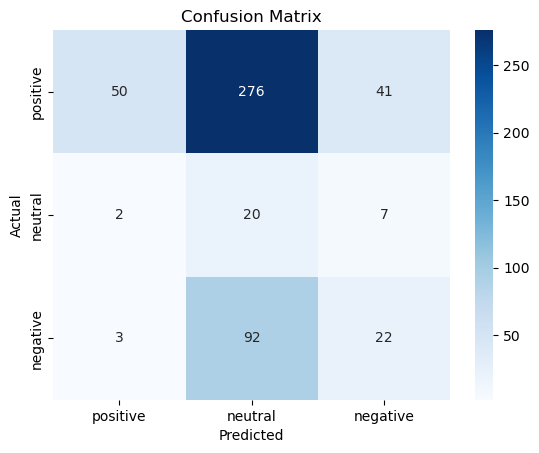

Predictions successfully saved locally at multinomial_reddit_predictions.csv
Predictions successfully saved to HDFS at /user/root/multinomial_reddit_predictions.csv


In [3]:
# --------------- MAIN LIBRARIES ------------------
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB  # Using Multinomial Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --------------- HELPING LIBRARIES ----------------
from sklearn.utils import resample
from hdfs import InsecureClient
import seaborn as sns
import matplotlib.pyplot as plt

# --------------- HDFS CONFIGURATION ----------------
hdfs_client = InsecureClient('http://localhost:9870', user='root')  # Update host as needed
hdfs_file_path = '/user/root/cleaned_election_posts.csv'
output_hdfs_path = '/user/root/multinomial_reddit_predictions.csv'  # Output file for predictions
output_local_path = 'multinomial_reddit_predictions.csv'  # Local file path for predictions

# Load train dataset and select only 'text' and 'sentiment' columns
train_dataset = 'train.csv'
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1', usecols=['text', 'sentiment'])
train_df = train_df.dropna()  # Remove rows with null values

# Load cleaned Reddit data from HDFS as test data
try:
    with hdfs_client.read(hdfs_file_path, encoding='utf-8') as hdfs_file:
        test_df = pd.read_csv(hdfs_file)
    print("Cleaned test data loaded successfully from HDFS.")
except Exception as e:
    print(f"Error loading cleaned text from HDFS: {e}")
    test_df = None

# Check if test_df is loaded
if test_df is not None:
    # --------------- TEXT PREPROCESSING ----------------
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')

    # Initialize VADER sentiment analyzer and lemmatizer
    sia = SentimentIntensityAnalyzer()
    lemmatizer = WordNetLemmatizer()

    # Preprocessing function
    def preprocess_text(text):
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
        return text

    # Apply preprocessing to the training data
    train_df['processed_text'] = train_df['text'].apply(preprocess_text)

    # Preprocessing already done for test_df; rename column for consistency
    test_df = test_df.rename(columns={'cleaned_text': 'processed_text'})

    # --------------- GENERATE SENTIMENT COLUMN ----------------
    # Generate sentiment labels for test_df using VADER
    def get_sentiment(text):
        sentiment_score = sia.polarity_scores(text)['compound']
        if sentiment_score > 0.05:
            return 'positive'
        elif sentiment_score < -0.05:
            return 'negative'
        else:
            return 'neutral'

    test_df['sentiment'] = test_df['processed_text'].apply(get_sentiment)

    # --------------- BALANCE TRAINING DATA ----------------
    majority = train_df[train_df['sentiment'] == 'neutral']
    minority_positive = train_df[train_df['sentiment'] == 'positive']
    minority_negative = train_df[train_df['sentiment'] == 'negative']

    # Oversample minority classes
    minority_positive_upsampled = resample(minority_positive, replace=True, n_samples=len(majority), random_state=42)
    minority_negative_upsampled = resample(minority_negative, replace=True, n_samples=len(majority), random_state=42)

    # Combine majority and oversampled minority classes
    train_df = pd.concat([majority, minority_positive_upsampled, minority_negative_upsampled])
    print("Balanced training data:")
    print(train_df['sentiment'].value_counts())

    # --------------- TF-IDF VECTORIZATION ----------------
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))  # Includes unigrams, bigrams, and trigrams
    train_TFIDF = vectorizer.fit_transform(train_df['processed_text'])
    test_TFIDF = vectorizer.transform(test_df['processed_text'])

    # Feature selection using chi-square
    selector = SelectKBest(chi2, k=5000)  # Select top 5000 features
    train_TFIDF = selector.fit_transform(train_TFIDF, train_df['sentiment'])
    test_TFIDF = selector.transform(test_TFIDF)

    # --------------- MULTINOMIAL NAIVE BAYES MODEL ----------------
    # Train Multinomial Naive Bayes model
    X = train_TFIDF
    y = train_df['sentiment']
    NB_model = MultinomialNB(alpha=0.1)  # Optimized smoothing parameter
    NB_model.fit(X, y)

    # Make predictions on the test data
    predictions = NB_model.predict(test_TFIDF)

    # Add predictions to test DataFrame
    test_df['predicted_sentiment'] = predictions

    # --------------- EVALUATE & SAVE RESULTS ----------------
    # Evaluate model performance
    print("Metrics Based on Sentiment vs Predicted Sentiment:")
    accuracy = accuracy_score(test_df['sentiment'], test_df['predicted_sentiment'])
    report = classification_report(test_df['sentiment'], test_df['predicted_sentiment'])
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(test_df['sentiment'], test_df['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive', 'neutral', 'negative'],
                yticklabels=['positive', 'neutral', 'negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Save predictions locally
    try:
        test_df.to_csv(output_local_path, index=False)
        print(f"Predictions successfully saved locally at {output_local_path}")
    except Exception as e:
        print(f"Error saving predictions locally: {e}")

    # Save predictions to HDFS
    try:
        with hdfs_client.write(output_hdfs_path, encoding='utf-8', overwrite=True) as hdfs_file:
            test_df.to_csv(hdfs_file, index=False)
        print(f"Predictions successfully saved to HDFS at {output_hdfs_path}")
    except Exception as e:
        print(f"Error saving predictions to HDFS: {e}")
else:
    print("Test data not available.")


Cleaned test data loaded successfully from HDFS.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Balanced training data:
neutral     12547
positive    12547
negative    12547
Name: sentiment, dtype: int64
Metrics Based on Sentiment vs Predicted Sentiment:
Accuracy: 32.75%
Classification Report:
              precision    recall  f1-score   support

    negative       0.34      0.47      0.39       117
     neutral       0.07      0.62      0.13        29
    positive       0.89      0.26      0.40       367

    accuracy                           0.33       513
   macro avg       0.43      0.45      0.31       513
weighted avg       0.72      0.33      0.38       513

Confusion Matrix:
[[ 95 173  99]
 [  2  18   9]
 [ 10  52  55]]


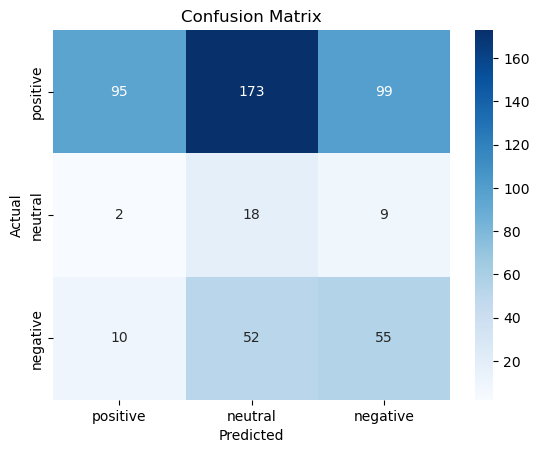

Predictions successfully saved locally at improved_reddit_predictions.csv
Predictions successfully saved to HDFS at /user/root/improved_reddit_predictions.csv


In [5]:
# --------------- MAIN LIBRARIES ------------------
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import ComplementNB  # Using Complement Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --------------- HELPING LIBRARIES ----------------
from sklearn.utils import resample
from hdfs import InsecureClient
import seaborn as sns
import matplotlib.pyplot as plt

# --------------- HDFS CONFIGURATION ----------------
hdfs_client = InsecureClient('http://localhost:9870', user='root')  # Update host as needed
hdfs_file_path = '/user/root/cleaned_election_posts.csv'
output_hdfs_path = '/user/root/improved_reddit_predictions.csv'  # Output file for predictions
output_local_path = 'improved_reddit_predictions.csv'  # Local file path for predictions

# Load train dataset and select only 'text' and 'sentiment' columns
train_dataset = 'train.csv'
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1', usecols=['text', 'sentiment'])
train_df = train_df.dropna()  # Remove rows with null values

# Load cleaned Reddit data from HDFS as test data
try:
    with hdfs_client.read(hdfs_file_path, encoding='utf-8') as hdfs_file:
        test_df = pd.read_csv(hdfs_file)
    print("Cleaned test data loaded successfully from HDFS.")
except Exception as e:
    print(f"Error loading cleaned text from HDFS: {e}")
    test_df = None

if test_df is not None:
    # --------------- TEXT PREPROCESSING ----------------
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')

    # Initialize VADER sentiment analyzer and lemmatizer
    sia = SentimentIntensityAnalyzer()
    lemmatizer = WordNetLemmatizer()

    # Preprocessing function
    def preprocess_text(text):
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
        return text

    # Apply preprocessing to the training data
    train_df['processed_text'] = train_df['text'].apply(preprocess_text)

    # Preprocessing already done for test_df; rename column for consistency
    test_df = test_df.rename(columns={'cleaned_text': 'processed_text'})

    # Generate actual sentiments for test data using the VADER-based sentiment analyzer
    def get_sentiment(text):
        sentiment_score = sia.polarity_scores(text)['compound']
        if sentiment_score > 0.05:
            return 'positive'
        elif sentiment_score < -0.05:
            return 'negative'
        else:
            return 'neutral'

    test_df['actual_sentiment'] = test_df['processed_text'].apply(get_sentiment)

    # --------------- BALANCE TRAINING DATA ----------------
    majority = train_df[train_df['sentiment'] == 'neutral']
    minority_positive = train_df[train_df['sentiment'] == 'positive']
    minority_negative = train_df[train_df['sentiment'] == 'negative']

    # Oversample minority classes
    minority_positive_upsampled = resample(minority_positive, replace=True, n_samples=len(majority), random_state=42)
    minority_negative_upsampled = resample(minority_negative, replace=True, n_samples=len(majority), random_state=42)

    # Combine majority and oversampled minority classes
    train_df = pd.concat([majority, minority_positive_upsampled, minority_negative_upsampled])
    print("Balanced training data:")
    print(train_df['sentiment'].value_counts())

    # --------------- TF-IDF VECTORIZATION ----------------
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))  # Includes unigrams, bigrams, and trigrams
    train_TFIDF = vectorizer.fit_transform(train_df['processed_text'])
    test_TFIDF = vectorizer.transform(test_df['processed_text'])

    # Feature selection using chi-square
    selector = SelectKBest(chi2, k=5000)  # Select top 5000 features
    train_TFIDF = selector.fit_transform(train_TFIDF, train_df['sentiment'])
    test_TFIDF = selector.transform(test_TFIDF)

    # --------------- COMPLEMENT NAIVE BAYES MODEL ----------------
    # Train Complement Naive Bayes model
    X = train_TFIDF
    y = train_df['sentiment']
    NB_model = ComplementNB(alpha=0.1)  # Optimized smoothing parameter
    NB_model.fit(X, y)

    # Make predictions on the test data
    predictions = NB_model.predict(test_TFIDF)

    # Add predictions to test DataFrame
    test_df['predicted_sentiment'] = predictions

    # --------------- EVALUATE & SAVE RESULTS ----------------
    print("Metrics Based on Sentiment vs Predicted Sentiment:")
    accuracy = accuracy_score(test_df['actual_sentiment'], test_df['predicted_sentiment'])
    report = classification_report(test_df['actual_sentiment'], test_df['predicted_sentiment'])
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(test_df['actual_sentiment'], test_df['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive', 'neutral', 'negative'],
                yticklabels=['positive', 'neutral', 'negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Save predictions locally
    try:
        test_df.to_csv(output_local_path, index=False)
        print(f"Predictions successfully saved locally at {output_local_path}")
    except Exception as e:
        print(f"Error saving predictions locally: {e}")

    # Save predictions to HDFS
    try:
        with hdfs_client.write(output_hdfs_path, encoding='utf-8', overwrite=True) as hdfs_file:
            test_df.to_csv(hdfs_file, index=False)
        print(f"Predictions successfully saved to HDFS at {output_hdfs_path}")
    except Exception as e:
        print(f"Error saving predictions to HDFS: {e}")
else:
    print("Test data not available.")


In [1]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load the dataset for training
train_df = pd.read_csv("train.csv", encoding='latin1')
train_df.dropna(subset=['text', 'sentiment'], inplace=True)  # Remove rows with NaN in critical columns

# Convert sentiments to numeric labels
sentiment_mapping = {"positive": 2, "neutral": 0, "negative": 1}
train_df['label'] = train_df['sentiment'].map(sentiment_mapping)

# Clean the text data
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    return text.strip()

train_df['cleaned_text'] = train_df['text'].apply(lambda x: clean_text(str(x)))  # Ensure all entries are strings

# Split the data into training and validation sets
train_split_df, val_split_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and validation data
train_encodings = tokenizer(list(train_split_df['cleaned_text']), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_split_df['cleaned_text']), truncation=True, padding=True, max_length=128)

# Create a Dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings, list(train_split_df['label']))
val_dataset = SentimentDataset(val_encodings, list(val_split_df['label']))

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    save_strategy="epoch",        # Save model at the end of every epoch
    save_total_limit=2,           # Keep only the last 2 checkpoints
    report_to="none"              # Disable WandB logging
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Load test data
from hdfs import InsecureClient

hdfs_client = InsecureClient('http://localhost:9870', user='root')  # Update host as needed
hdfs_file_path = '/user/root/cleaned_election_posts.csv'

try:
    with hdfs_client.read(hdfs_file_path, encoding='utf-8') as hdfs_file:
        test_df = pd.read_csv(hdfs_file)
    print("Cleaned test data loaded successfully from HDFS.")
except Exception as e:
    print(f"Error loading cleaned text from HDFS: {e}")
    test_df = None

if test_df is not None:
    # Ensure test_df contains processed text
    if 'processed_text' not in test_df.columns:
        test_df = test_df.rename(columns={'cleaned_text': 'processed_text'})

    test_df['cleaned_text'] = test_df['processed_text'].apply(lambda x: clean_text(str(x)))

    # Tokenize the test data
    test_encodings = tokenizer(list(test_df['cleaned_text']), truncation=True, padding=True, max_length=128)

    # Create a test dataset
    test_dataset = SentimentDataset(test_encodings, [0] * len(test_df))  # Placeholder labels since they will not be used during evaluation

    # Evaluate the model on the test dataset
    test_predictions = trainer.predict(test_dataset)
    test_predicted_labels = torch.argmax(torch.tensor(test_predictions.predictions), axis=1).numpy()

    # Map numeric predictions back to sentiment labels
    reverse_sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}
    test_df['predicted_sentiment'] = test_predicted_labels
    test_df['predicted_sentiment'] = test_df['predicted_sentiment'].map(reverse_sentiment_mapping)

    # Save the predictions
    output_hdfs_path = '/user/root/bert_reddit_predictions.csv'
    output_local_path = 'bert_reddit_predictions.csv'

    # Save locally
    test_df.to_csv(output_local_path, index=False)
    print(f"Predictions saved locally to {output_local_path}.")

    # Save to HDFS
    try:
        with hdfs_client.write(output_hdfs_path, encoding='utf-8', overwrite=True) as hdfs_file:
            test_df.to_csv(hdfs_file, index=False)
        print(f"Predictions successfully saved to HDFS at {output_hdfs_path}.")
    except Exception as e:
        print(f"Error saving predictions to HDFS: {e}")

    # Display predictions
    print("Test Data with Predictions:")
    print(test_df[['cleaned_text', 'predicted_sentiment']].head())


c:\Users\parek\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\parek\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\parek\anaconda3\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/9306 [00:00<?, ?it/s]

{'loss': 1.0823, 'grad_norm': 4.338676452636719, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 1.1001, 'grad_norm': 3.869293451309204, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 1.0914, 'grad_norm': 5.781430244445801, 'learning_rate': 3e-06, 'epoch': 0.01}
{'loss': 1.1177, 'grad_norm': 5.249660968780518, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}
{'loss': 1.0466, 'grad_norm': 4.611331462860107, 'learning_rate': 5e-06, 'epoch': 0.02}
{'loss': 1.049, 'grad_norm': 3.2670249938964844, 'learning_rate': 6e-06, 'epoch': 0.02}
{'loss': 1.0464, 'grad_norm': 5.249567985534668, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.02}
{'loss': 1.0989, 'grad_norm': 7.326991558074951, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.03}
{'loss': 1.0521, 'grad_norm': 4.9591803550720215, 'learning_rate': 9e-06, 'epoch': 0.03}
{'loss': 1.0752, 'grad_norm': 8.952446937561035, 'learning_rate': 1e-05, 'epoch': 0.03}
{'loss': 1.0491, 'grad_norm': 8.054713

  0%|          | 0/776 [00:00<?, ?it/s]

{'eval_loss': 0.5922034382820129, 'eval_runtime': 315.1135, 'eval_samples_per_second': 19.685, 'eval_steps_per_second': 2.463, 'epoch': 1.0}
{'loss': 0.5463, 'grad_norm': 4.755762100219727, 'learning_rate': 3.518055870997047e-05, 'epoch': 1.0}
{'loss': 0.5318, 'grad_norm': 4.539275646209717, 'learning_rate': 3.5123779241426304e-05, 'epoch': 1.01}
{'loss': 0.3272, 'grad_norm': 9.11245059967041, 'learning_rate': 3.506699977288212e-05, 'epoch': 1.01}
{'loss': 0.4725, 'grad_norm': 5.170708656311035, 'learning_rate': 3.5010220304337956e-05, 'epoch': 1.01}
{'loss': 0.4046, 'grad_norm': 5.797034740447998, 'learning_rate': 3.4953440835793775e-05, 'epoch': 1.02}
{'loss': 0.3924, 'grad_norm': 2.0896265506744385, 'learning_rate': 3.489666136724961e-05, 'epoch': 1.02}
{'loss': 0.5815, 'grad_norm': 46.84423828125, 'learning_rate': 3.4839881898705426e-05, 'epoch': 1.02}
{'loss': 0.7994, 'grad_norm': 19.820404052734375, 'learning_rate': 3.478310243016126e-05, 'epoch': 1.03}
{'loss': 0.5149, 'grad_nor

  0%|          | 0/776 [00:00<?, ?it/s]

{'eval_loss': 0.6180144548416138, 'eval_runtime': 368.5942, 'eval_samples_per_second': 16.829, 'eval_steps_per_second': 2.105, 'epoch': 2.0}
{'loss': 0.3425, 'grad_norm': 10.84139633178711, 'learning_rate': 1.7578923461276404e-05, 'epoch': 2.0}
{'loss': 0.222, 'grad_norm': 2.6758604049682617, 'learning_rate': 1.752214399273223e-05, 'epoch': 2.01}
{'loss': 0.1467, 'grad_norm': 0.8121783137321472, 'learning_rate': 1.7465364524188056e-05, 'epoch': 2.01}
{'loss': 0.4428, 'grad_norm': 5.66715669631958, 'learning_rate': 1.740858505564388e-05, 'epoch': 2.01}
{'loss': 0.3356, 'grad_norm': 0.4156278669834137, 'learning_rate': 1.7351805587099707e-05, 'epoch': 2.01}
{'loss': 0.3187, 'grad_norm': 10.772849082946777, 'learning_rate': 1.7295026118555533e-05, 'epoch': 2.02}
{'loss': 0.437, 'grad_norm': 8.2828950881958, 'learning_rate': 1.7238246650011355e-05, 'epoch': 2.02}
{'loss': 0.3065, 'grad_norm': 18.86196517944336, 'learning_rate': 1.718146718146718e-05, 'epoch': 2.02}
{'loss': 0.4151, 'grad_n

  0%|          | 0/776 [00:00<?, ?it/s]

{'eval_loss': 0.8516367077827454, 'eval_runtime': 397.4047, 'eval_samples_per_second': 15.609, 'eval_steps_per_second': 1.953, 'epoch': 3.0}
{'train_runtime': 20283.9865, 'train_samples_per_second': 3.67, 'train_steps_per_second': 0.459, 'train_loss': 0.4839686017099975, 'epoch': 3.0}
Cleaned test data loaded successfully from HDFS.


  0%|          | 0/64 [00:00<?, ?it/s]

Predictions saved locally to bert_reddit_predictions.csv.
Predictions successfully saved to HDFS at /user/root/bert_reddit_predictions.csv.
Test Data with Predictions:
                                        cleaned_text predicted_sentiment
0  secret many people reddit including believe se...            negative
1  donald trump reshaped republican party last de...             neutral
2  hear threat lot democracy stake trump wins say...             neutral
3  donald trump loses year election longer factor...            negative
4  trump ran clinton would first woman us preside...            negative


In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to determine sentiment using VADER
def get_sentiment_vader(text):
    sentiment_score = sia.polarity_scores(text)['compound']
    if sentiment_score > 0.05:
        return 'positive'
    elif sentiment_score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Add 'actual_sentiment' column to test_df using the VADER-based sentiment analyzer
test_df['actual_sentiment'] = test_df['cleaned_text'].apply(get_sentiment_vader)

# Display the updated DataFrame
print(test_df[['cleaned_text', 'predicted_sentiment', 'actual_sentiment']].head())

from hdfs import InsecureClient

# HDFS Configuration
hdfs_client = InsecureClient('http://localhost:9870', user='root')  # Update host and user as needed
output_hdfs_path = '/user/root/vader_sentiment_predictions.csv'  # HDFS file path
output_local_path = 'vader_sentiment_predictions.csv'  # Local file path

# Save locally
try:
    test_df.to_csv(output_local_path, index=False)
    print(f"Predictions with VADER sentiment saved locally to {output_local_path}.")
except Exception as e:
    print(f"Error saving predictions locally: {e}")

# Save to HDFS
try:
    with hdfs_client.write(output_hdfs_path, encoding='utf-8', overwrite=True) as hdfs_file:
        test_df.to_csv(hdfs_file, index=False)
    print(f"Predictions with VADER sentiment successfully saved to HDFS at {output_hdfs_path}.")
except Exception as e:
    print(f"Error saving predictions to HDFS: {e}")



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\parek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                        cleaned_text predicted_sentiment  \
0  secret many people reddit including believe se...            negative   
1  donald trump reshaped republican party last de...             neutral   
2  hear threat lot democracy stake trump wins say...             neutral   
3  donald trump loses year election longer factor...            negative   
4  trump ran clinton would first woman us preside...            negative   

  actual_sentiment  
0         positive  
1         positive  
2          neutral  
3          neutral  
4         positive  
Predictions with VADER sentiment saved locally to vader_sentiment_predictions.csv.
Predictions with VADER sentiment successfully saved to HDFS at /user/root/vader_sentiment_predictions.csv.


Accuracy: 29.69%
Classification Report:
              precision    recall  f1-score   support

    negative       0.54      0.37      0.44       117
     neutral       0.06      0.76      0.12        29
    positive       0.95      0.24      0.38       366

    accuracy                           0.30       512
   macro avg       0.52      0.45      0.31       512
weighted avg       0.80      0.30      0.38       512



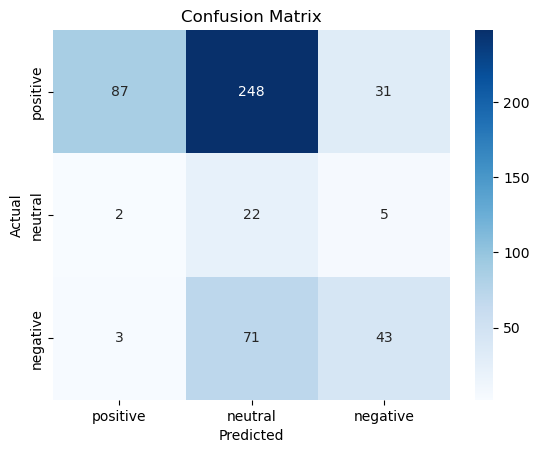

In [3]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(test_df['actual_sentiment'], test_df['predicted_sentiment'])
print(f"Accuracy: {accuracy:.2%}")

# Classification report
report = classification_report(test_df['actual_sentiment'], test_df['predicted_sentiment'])
print("Classification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_df['actual_sentiment'], test_df['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


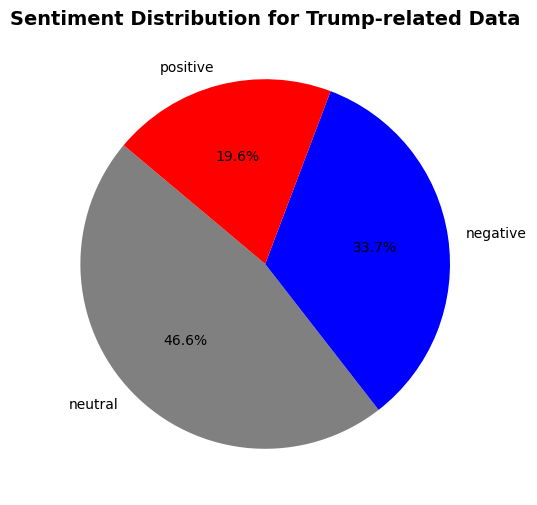

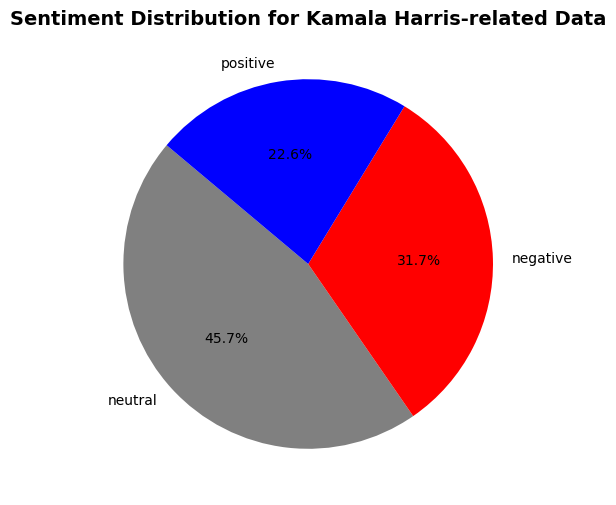

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = 'improved_reddit_predictions.csv'
df = pd.read_csv(file_path)

# Ensure necessary columns exist
if 'processed_text' in df.columns and 'predicted_sentiment' in df.columns:
    # Filter Trump-related data
    trump_data = df[df['processed_text'].str.contains('trump', case=False, na=False)]
    trump_sentiment_counts = trump_data['predicted_sentiment'].value_counts()

    # Filter Kamala Harris-related data
    kamala_data = df[df['processed_text'].str.contains('kamala', case=False, na=False)]
    kamala_sentiment_counts = kamala_data['predicted_sentiment'].value_counts()

    # Define color schemes
    trump_colors = {'positive': 'red', 'neutral': 'gray', 'negative': 'blue'}
    kamala_colors = {'positive': 'blue', 'neutral': 'gray', 'negative': 'red'}

    # Generate Pie Chart for Trump-related data
    plt.figure(figsize=(8, 6))
    plt.pie(trump_sentiment_counts, labels=trump_sentiment_counts.index, autopct='%1.1f%%',
            startangle=140, colors=[trump_colors[sentiment] for sentiment in trump_sentiment_counts.index])
    plt.title('Sentiment Distribution for Trump-related Data', fontsize=14, fontweight='bold')
    plt.show()

    # Generate Pie Chart for Kamala Harris-related data
    plt.figure(figsize=(8, 6))
    plt.pie(kamala_sentiment_counts, labels=kamala_sentiment_counts.index, autopct='%1.1f%%',
            startangle=140, colors=[kamala_colors[sentiment] for sentiment in kamala_sentiment_counts.index])
    plt.title('Sentiment Distribution for Kamala Harris-related Data', fontsize=14, fontweight='bold')
    plt.show()
else:
    print("Required columns ('processed_text', 'predicted_sentiment') not found in the dataset.")
